In [1]:
import gpxpy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from matplotlib.colors import LogNorm, PowerNorm  # Added import for logarithmic and power normalization
import contextily as ctx
import geopandas as gpd
from pyproj import CRS

def load_gpx_data(gpx_file):
    """Load GPX file and extract timestamps and coordinates, adjusting UTC time to local time (PDT)."""
    with open(gpx_file, 'r') as gpx_file:
        gpx = gpxpy.parse(gpx_file)
    
    points = []
    for track in gpx.tracks:
        for segment in track.segments:
            for point in segment.points:
                # Adjust UTC time to local time (subtract 7 hours for PDT)
                local_time = point.time.replace(tzinfo=None) - timedelta(hours=7)
                points.append({
                    'timestamp': local_time,
                    'latitude': point.latitude,
                    'longitude': point.longitude
                })
    
    return pd.DataFrame(points)

def load_ping_data(csv_file):
    """Load ping data from CSV file."""
    df = pd.read_csv(csv_file)
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    return df

def match_ping_to_location(gpx_df, ping_df):
    """Match ping data to closest GPS coordinates by timestamp."""
    matched_data = []
    
    for _, ping_row in ping_df.iterrows():
        ping_time = ping_row['timestamp']
        
        # Find absolute time difference with all GPS points
        time_diffs = abs(gpx_df['timestamp'] - ping_time)
        
        # Get the index of the closest point
        closest_idx = time_diffs.argmin()
        closest_point = gpx_df.iloc[closest_idx]
        
        matched_data.append({
            'timestamp': ping_time,
            'latitude': closest_point['latitude'],
            'longitude': closest_point['longitude'],
            'min_ms': ping_row['min_ms'],
            'avg_ms': ping_row['avg_ms'],
            'max_ms': ping_row['max_ms'],
            'packet_loss': ping_row['packet_loss'],
            'time_diff_seconds': time_diffs[closest_idx].total_seconds()
        })
    
    return pd.DataFrame(matched_data)

# After loading ping_df, add this code to insert synthetic entries for gaps
def fill_gaps_with_synthetic_data(df, threshold_seconds=7):
    """Insert synthetic entries where gaps exist in ping data."""
    df = df.sort_values('timestamp').copy()
    synthetic_entries = []
    
    for i in range(len(df) - 1):
        current_time = df.iloc[i]['timestamp']
        next_time = df.iloc[i + 1]['timestamp']
        time_diff = (next_time - current_time).total_seconds()
        
        if time_diff > threshold_seconds:
            # Calculate number of missing entries
            missing_intervals = int(time_diff / 5) - 1  # 5 seconds is normal interval
            
            for j in range(missing_intervals):
                synthetic_time = current_time + timedelta(seconds=(j + 1) * 5)
                synthetic_entries.append({
                    'timestamp': synthetic_time,
                    'min_ms': 4000,
                    'avg_ms': 4000,
                    'max_ms': 4000,
                    'packet_loss': 100.0  # 100% packet loss
                })
    
    # Add synthetic entries to original dataframe
    if synthetic_entries:
        synthetic_df = pd.DataFrame(synthetic_entries)
        df = pd.concat([df, synthetic_df], ignore_index=True)
        df = df.sort_values('timestamp').reset_index(drop=True)
    
    return df

# File paths for both runs
gpx_file_paths = ["1strun.gpx", "run2.gpx"]
ping_csv_paths = ["ping_log.csv", "ping_log2.csv"]

# Initialize empty DataFrames
gpx_df = pd.DataFrame()
ping_df = pd.DataFrame()

# Load and combine data from both sets
for gpx_path, ping_path in zip(gpx_file_paths, ping_csv_paths):
    # Load and combine GPX data
    current_gpx_df = load_gpx_data(gpx_path)
    gpx_df = pd.concat([gpx_df, current_gpx_df], ignore_index=True)
    
    # Load and combine ping data
    current_ping_df = load_ping_data(ping_path)
    current_ping_df = fill_gaps_with_synthetic_data(current_ping_df)
    ping_df = pd.concat([ping_df, current_ping_df], ignore_index=True)

# Sort both DataFrames by timestamp to ensure proper ordering
gpx_df = gpx_df.sort_values('timestamp').reset_index(drop=True)
ping_df = ping_df.sort_values('timestamp').reset_index(drop=True)


/Users/albertohojel/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


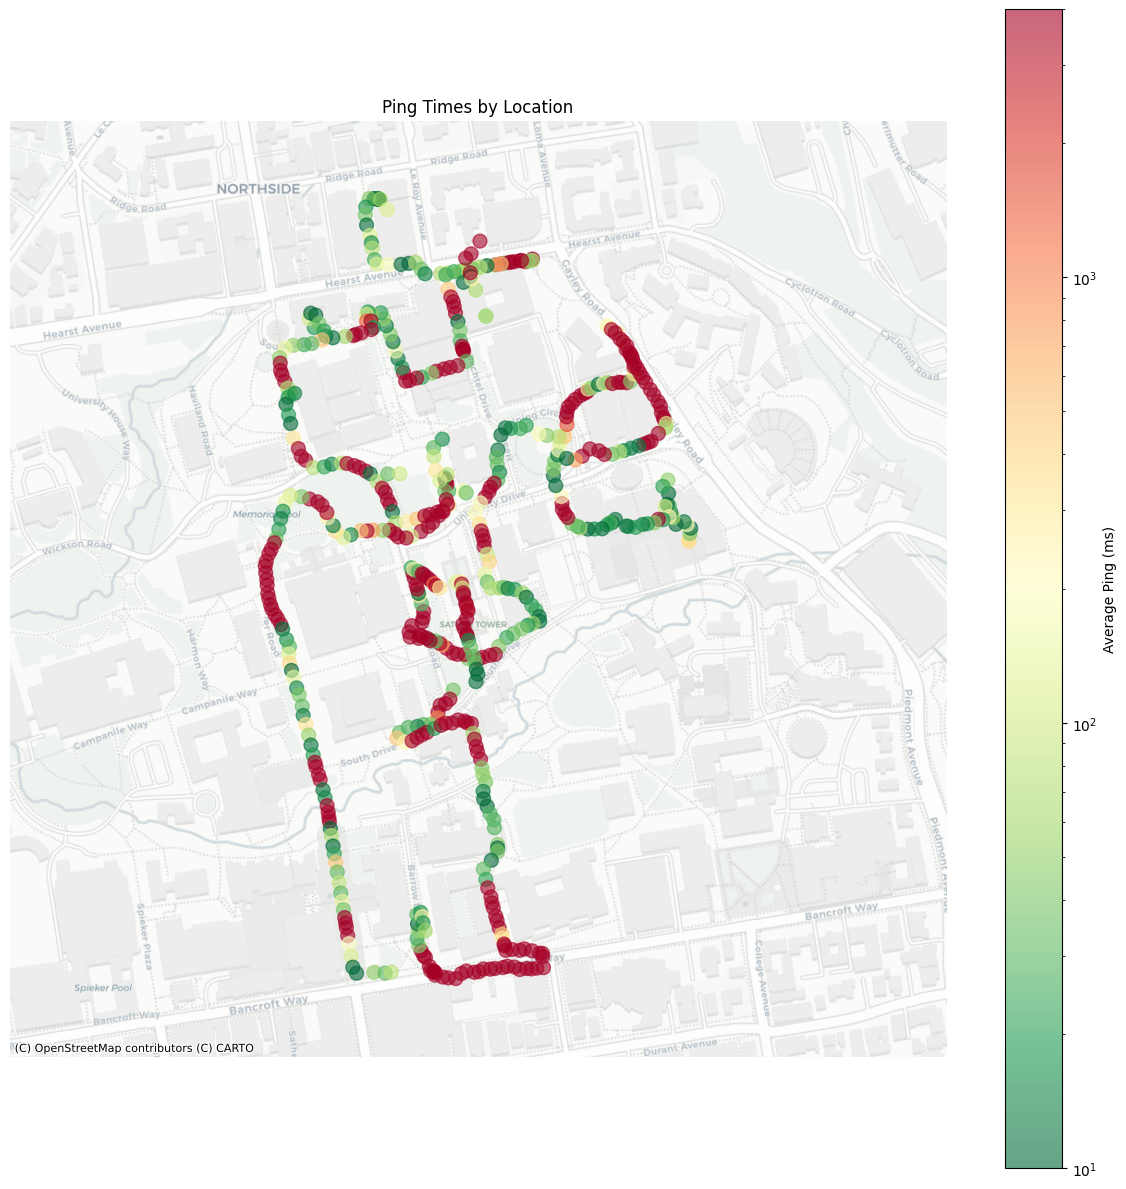

In [6]:

# Match ping data with GPS locations
matched_data = match_ping_to_location(gpx_df, ping_df)
# Filter to only include points where GPS and ping timestamps are within 10 seconds
matched_data = matched_data[matched_data["time_diff_seconds"]<=10]
#matched_data = matched_data[matched_data["avg_ms"]<=600]
# Create a GeoDataFrame from your matched_data
gdf = gpd.GeoDataFrame(
    matched_data, 
    geometry=gpd.points_from_xy(matched_data.longitude, matched_data.latitude),
    crs=CRS('EPSG:4326')
)

# Convert to Web Mercator projection for the basemap
gdf = gdf.to_crs(epsg=3857)

# Calculate the center point and span for a square view
bounds = gdf.geometry.total_bounds
center_x = (bounds[0] + bounds[2]) / 2
center_y = (bounds[1] + bounds[3]) / 2
span = max(bounds[2] - bounds[0], bounds[3] - bounds[1])

# Create a square boundary with some padding
padding = 1.2

# Create the figure and axis with square dimensions
fig, ax = plt.subplots(figsize=(12, 12))

# Set the limits of the plot to ensure a square view with padding
ax.set_xlim(center_x - span/2 * padding, center_x + span/2 * padding)
ax.set_ylim(center_y - span/2 * padding, center_y + span/2 * padding)

# Ensure equal aspect ratio for true shape
ax.set_aspect('equal')

# Create scatter plot with the projected coordinates
scatter = ax.scatter(
    gdf.geometry.x,
    gdf.geometry.y,
    c=gdf['avg_ms'],
    cmap='RdYlGn_r',
    s=100,
    alpha=0.6,
    norm=LogNorm(vmin=10, vmax=4000)
)

# Add the basemap
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

# Add colorbar
cbar = plt.colorbar(scatter, label='Average Ping (ms)')

# Customize the plot
plt.title('Ping Times by Location')

# Remove axis labels since we have a map
ax.set_axis_off()

# Adjust layout
plt.tight_layout()

# Display the plot
plt.show()


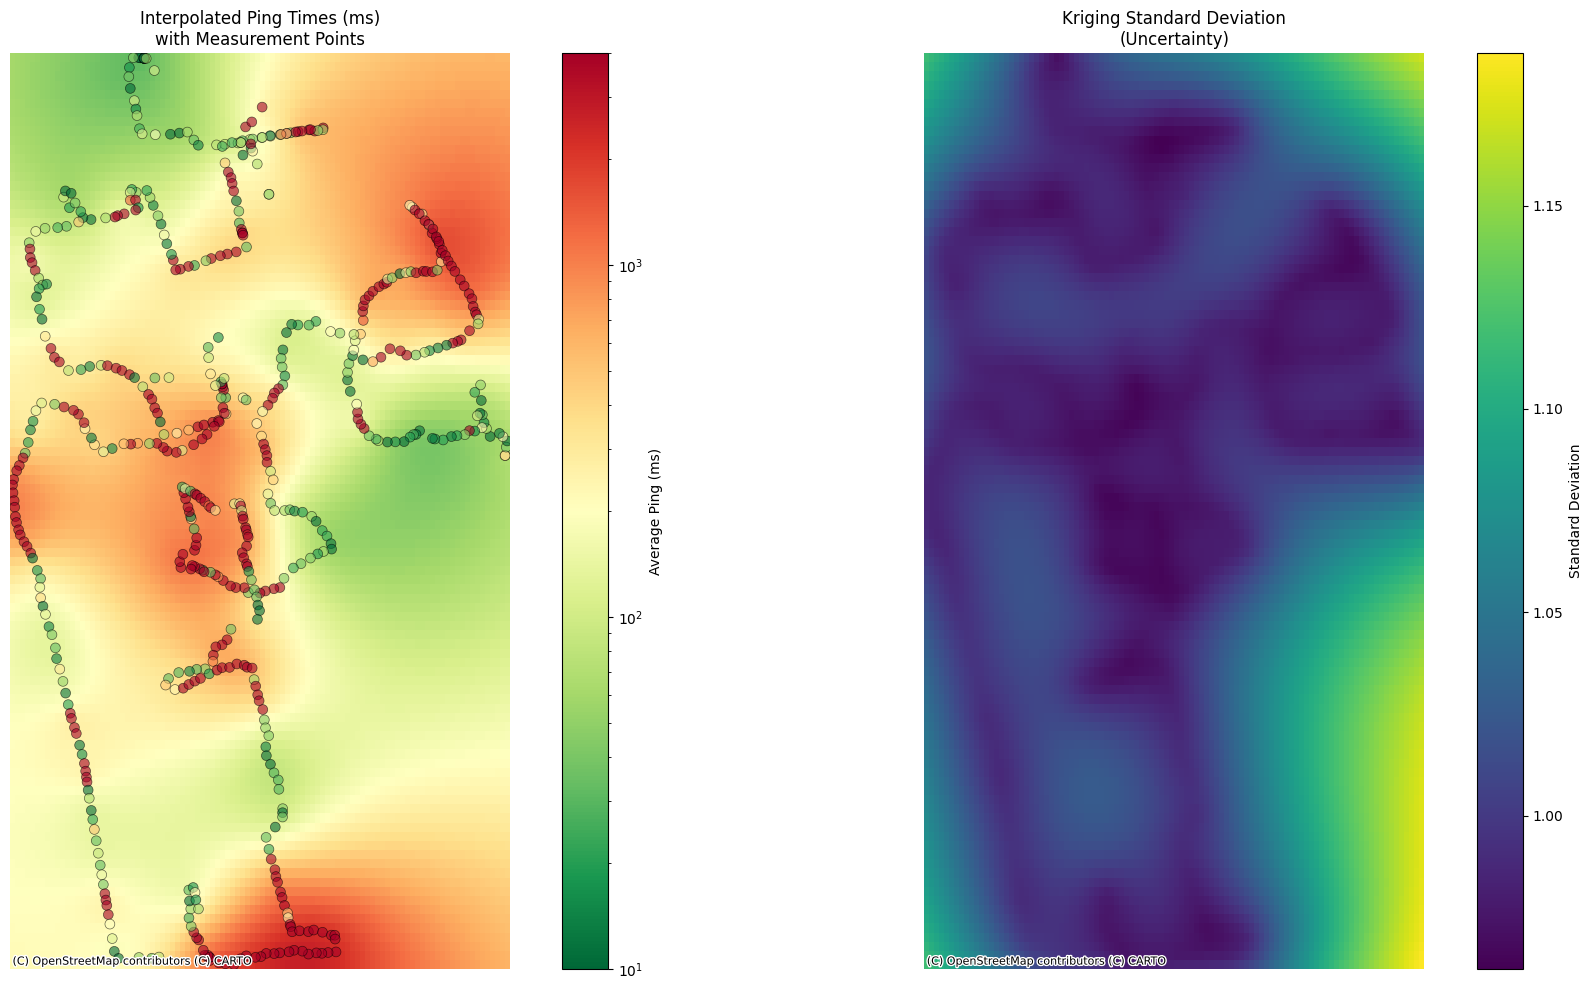

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import contextily as ctx
from matplotlib.colors import LogNorm
from pykrige.ok import OrdinaryKriging

def perform_ordinary_kriging(gdf, resolution=100):
    """Perform ordinary kriging on the ping data using PyKrige."""
    # Extract coordinates and values
    x = gdf.geometry.x.values
    y = gdf.geometry.y.values
    # Apply log transformation to the values
    z = np.log10(gdf['avg_ms'].values)
    
    # Create grid for interpolation
    bounds = gdf.geometry.total_bounds
    grid_x = np.linspace(bounds[0], bounds[2], resolution)
    grid_y = np.linspace(bounds[1], bounds[3], resolution)
    
    # Create and execute kriging
    OK = OrdinaryKriging(
        x, y, z,
        variogram_model='exponential',
        verbose=False,
        enable_plotting=False
    )
    
    # Execute kriging on grid
    field, sigma = OK.execute('grid', grid_x, grid_y)
    
    # Transform results back to original scale
    field = 10**field
    
    # Create meshgrid for plotting
    grid_xx, grid_yy = np.meshgrid(grid_x, grid_y)
    
    return grid_xx, grid_yy, field, sigma

def plot_kriging_results(gdf, grid_xx, grid_yy, field, sigma):
    """Plot the kriging results with the original points."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    
    # Plot 1: Kriging interpolation with points
    im1 = ax1.pcolormesh(
        grid_xx, grid_yy, field,
        cmap='RdYlGn_r',
        norm=LogNorm(vmin=10, vmax=4000),
        shading='auto'
    )
    
    # Add original points
    scatter = ax1.scatter(
        gdf.geometry.x,
        gdf.geometry.y,
        c=gdf['avg_ms'],
        cmap='RdYlGn_r',
        s=50,
        alpha=0.6,
        norm=LogNorm(vmin=10, vmax=4000),
        edgecolor='black',
        linewidth=0.5
    )
    
    # Plot 2: Kriging standard deviation
    im2 = ax2.pcolormesh(
        grid_xx, grid_yy, sigma,
        cmap='viridis',
        shading='auto'
    )
    
    # Add basemaps
    ctx.add_basemap(ax1, source=ctx.providers.CartoDB.Positron)
    ctx.add_basemap(ax2, source=ctx.providers.CartoDB.Positron)
    
    # Customize plots
    ax1.set_title('Interpolated Ping Times (ms)\nwith Measurement Points')
    ax2.set_title('Kriging Standard Deviation\n(Uncertainty)')
    
    # Add colorbars
    plt.colorbar(im1, ax=ax1, label='Average Ping (ms)')
    plt.colorbar(im2, ax=ax2, label='Standard Deviation')
    
    # Set equal aspect ratios and remove axes
    ax1.set_aspect('equal')
    ax2.set_aspect('equal')
    ax1.set_axis_off()
    ax2.set_axis_off()
    
    # Adjust layout
    plt.tight_layout()
    
    return fig

# Main execution
grid_xx, grid_yy, field, sigma = perform_ordinary_kriging(gdf)
fig = plot_kriging_results(gdf, grid_xx, grid_yy, field, sigma)
plt.show()

In [62]:
pip install pykrige

  Obtaining dependency information for pykrige from https://files.pythonhosted.org/packages/ac/91/1282b2561a455eda659b481816771f722b3c68fad75506a5d4d70d0f1726/PyKrige-1.7.2-cp311-cp311-macosx_11_0_arm64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.7/212.7 kB 3.5 MB/s eta 0:00:00 0:00:01
Note: you may need to restart the kernel to use updated packages.


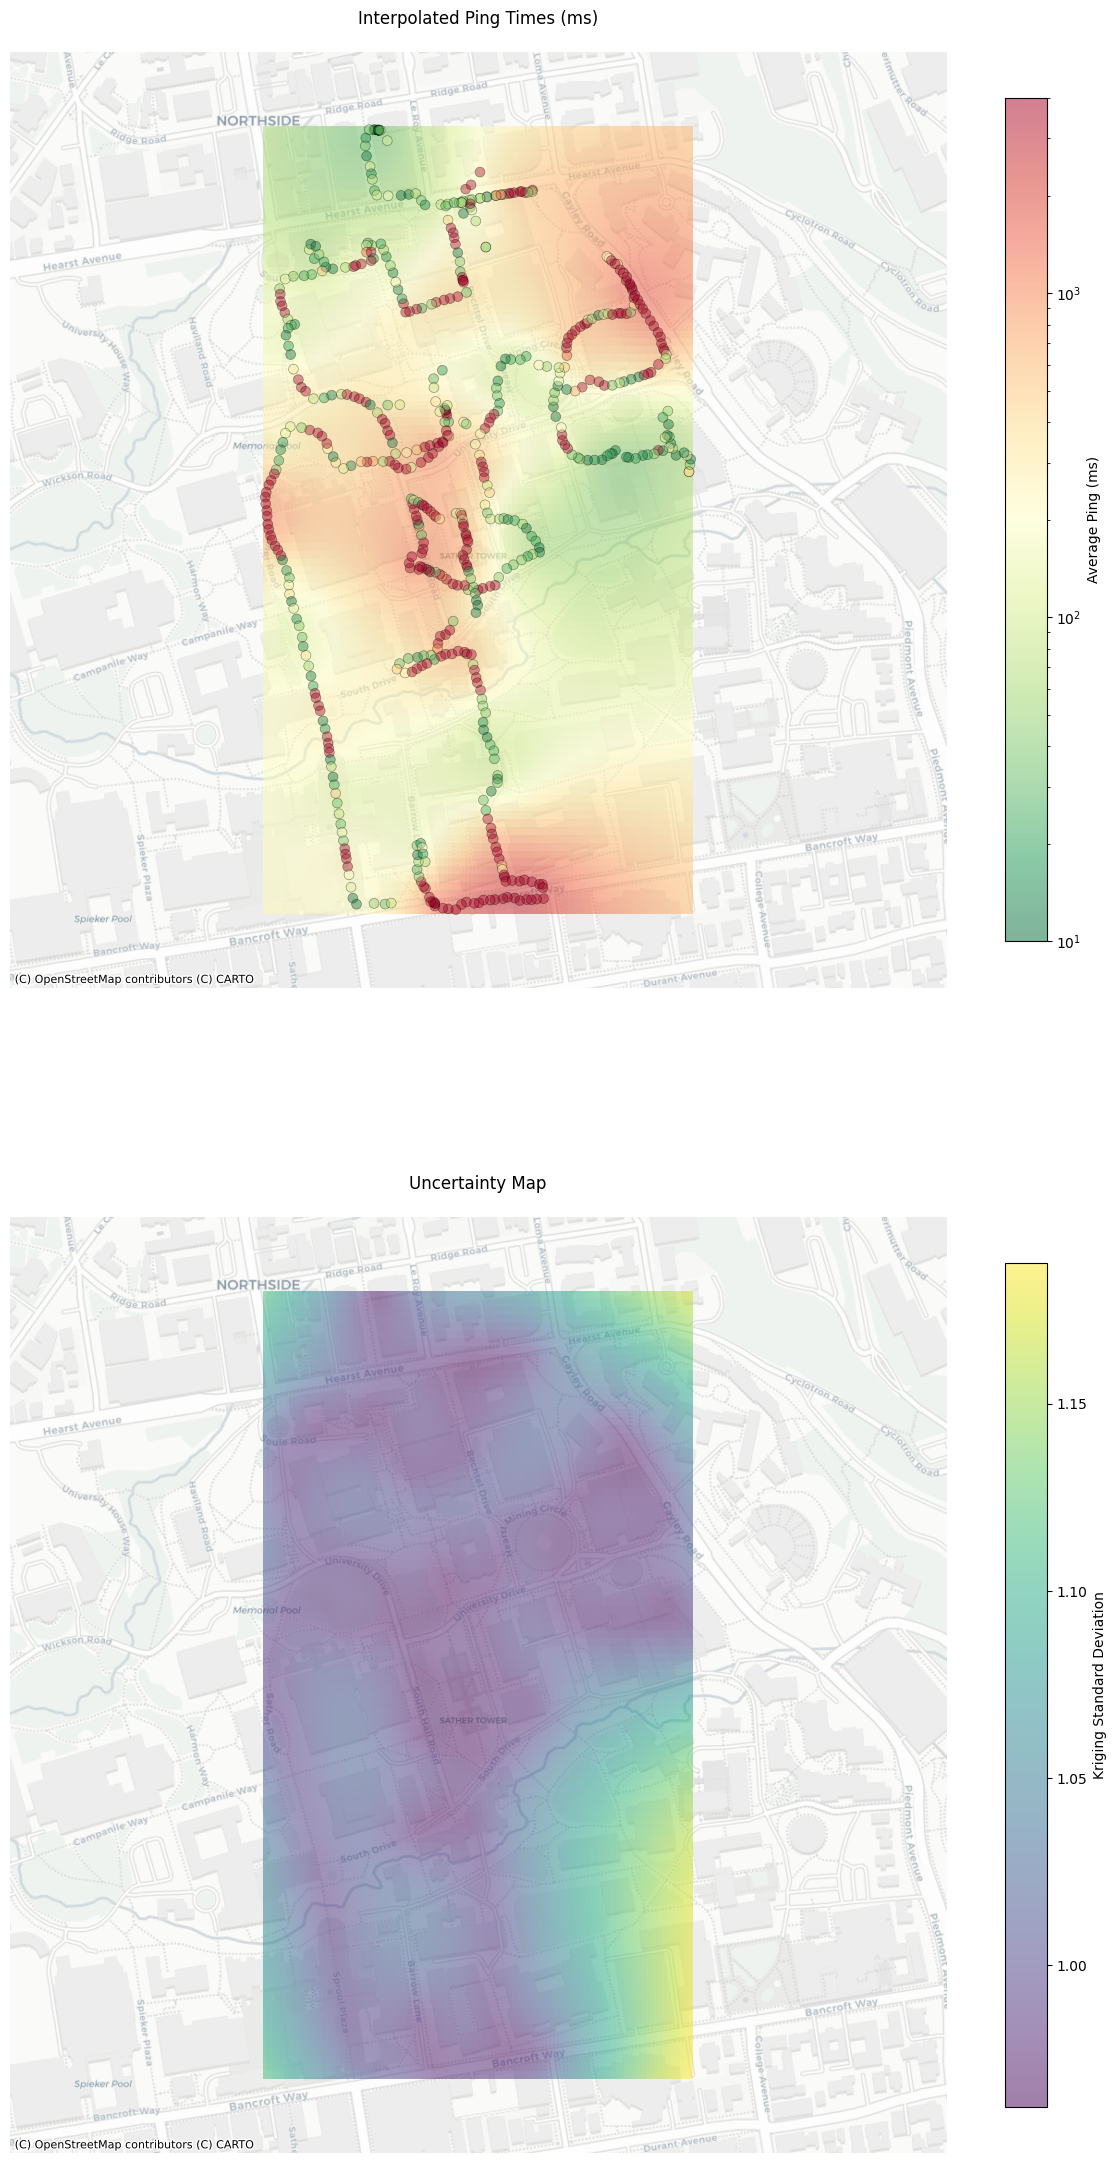

In [5]:
# Create the figure and axes with vertical stacking
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 24))

# Set the limits for both plots
for ax in [ax1, ax2]:
    ax.set_xlim(center_x - span/2 * padding, center_x + span/2 * padding)
    ax.set_ylim(center_y - span/2 * padding, center_y + span/2 * padding)
    ax.set_aspect('equal')
    ax.set_axis_off()

# Perform kriging
grid_xx, grid_yy, field, sigma = perform_ordinary_kriging(gdf)

# Plot 1: Interpolated values
im1 = ax1.pcolormesh(
    grid_xx, grid_yy, field,
    cmap='RdYlGn_r',
    norm=LogNorm(vmin=10, vmax=4000),
    shading='auto',
    alpha=0.5  # Reduced from 0.7
)

# Add original points to interpolation plot
scatter = ax1.scatter(
    gdf.geometry.x,
    gdf.geometry.y,
    c=gdf['avg_ms'],
    cmap='RdYlGn_r',
    s=50,
    alpha=0.4,  # Reduced from 0.6
    norm=LogNorm(vmin=10, vmax=4000),
    edgecolor='black',
    linewidth=0.5
)

# Plot 2: Uncertainty
im2 = ax2.pcolormesh(
    grid_xx, grid_yy, sigma,
    cmap='viridis',
    shading='auto',
    alpha=0.5  # Reduced from 0.7
)

# Add basemaps with a different style that has more contrast
ctx.add_basemap(ax1, source=ctx.providers.CartoDB.Positron)  # Changed from Positron
ctx.add_basemap(ax2, source=ctx.providers.CartoDB.Positron)  # Changed from Positron

# Add colorbars with reduced size
cbar1 = plt.colorbar(im1, ax=ax1, label='Average Ping (ms)', shrink=0.7)
cbar2 = plt.colorbar(im2, ax=ax2, label='Kriging Standard Deviation', shrink=0.7)

# Add titles
ax1.set_title('Interpolated Ping Times (ms)', pad=20)
ax2.set_title('Uncertainty Map', pad=20)

plt.tight_layout()
plt.show()